In [1]:
from __future__ import print_function
from firedrake import *
from firedrake_adjoint import *
import numpy as np
import os, sys
import spyro
import numpy as np
import math
import matplotlib.pyplot as plot
import matplotlib.ticker      as mticker  
from matplotlib               import cm
from mpl_toolkits.axes_grid1  import make_axes_locatable
import memory_profiler

model = {}

# Choose method and parameters
model["opts"] = {
    "method": "KMV",  # either CG or KMV
    "quadratrue": "KMV", # Equi or KMV
    "degree": 1,  # p order
    "dimension": 2,  # dimension
}

# Number of cores for the shot. For simplicity, we keep things serial.
# spyro however supports both spatial parallelism and "shot" parallelism.
model["parallelism"] = {
    "type": "spatial",  # options: automatic (same number of cores for evey processor), custom, off.
    "custom_cores_per_shot": [],  # only if the user wants a different number of cores for every shot.
    "num_cores_per_shot": 1
    # input is a list of integers with the length of the number of shots.
}

# Define the domain size without the PML. Here we'll assume a 0.75 x 1.50 km
# domain and reserve the remaining 250 m for the Perfectly Matched Layer (PML) to absorb
# outgoing waves on three sides (eg., -z, +-x sides) of the domain.
model["mesh"] = {
    "Lz": 0.75,  # depth in km - always positive
    "Lx": 1.5,  # width in km - always positive
    "Ly": 0.0,  # thickness in km - always positive
    "meshfile": "not_used.msh",
    "initmodel": "not_used.hdf5",
    "truemodel": "not_used.hdf5",
}

model["BCs"] = {
    "status":False,  # True or false
    "outer_bc": "non-reflective",  #  neumann, non-reflective (outer boundary condition)
    "damping_type": "polynomial",  # polynomial. hyperbolic, shifted_hyperbolic
    "exponent": 1,
    "cmax": 4.7,  # maximum acoustic wave velocity in PML - km/s
    "R": 0.001,  # theoretical reflection coefficient
    "lz": 0.5,  # thickness of the pml in the z-direction (km) - always positive
    "lx": 0.5,  # thickness of the pml in the x-direction (km) - always positive
    "ly": 0.0,  # thickness of the pml in the y-direction (km) - always positive
}

model["acquisition"] = {
    "source_type": "Ricker",
    "num_sources": 2,
    "source_pos": spyro.create_transect((0.1, 0.2), (0.1, 0.8), 2),
    "frequency": 3.0,
    "delay": 1.0,
    "num_receivers": 100,
    "receiver_locations": spyro.create_transect(
        (0.10, 0.1), (0.10, 0.9), 100
    ),
}

# Simulate for 2.0 seconds.
model["timeaxis"] = {
    "t0": 0.0,  #  Initial time for event
    "tf": 1.00,  # Final time for event
    "dt": 0.001,  # timestep size
    "amplitude": 1,  # the Ricker has an amplitude of 1.
    "nspool": 100,  # how frequently to output solution to pvds
    "fspool": 100,  # how frequently to save solution to RAM
}


num_rec = model["acquisition"]["num_receivers"]
δs = np.linspace(0.1, 0.9, num_rec)
X, Y = np.meshgrid(0.1, δs)
xs = np.vstack((X.flatten(), Y.flatten())).T
mesh = RectangleMesh(100, 100, 1.0, 1.0)

In [2]:
# Create the computational environment
comm = spyro.utils.mpi_init(model)

element = spyro.domains.space.FE_method(
    mesh, model["opts"]["method"], model["opts"]["degree"]
)
V = FunctionSpace(mesh, element)

x, y = SpatialCoordinate(mesh)
velocity = conditional(x > 0.35, 1.5, 3)
vp   = Function(V, name="vp").interpolate(velocity)


In [3]:
sources = spyro.Sources(model, mesh, V, comm).create()
tf   = model["timeaxis"]["tf"] 
dt   = model["timeaxis"]["dt"]
freq = model["acquisition"]["frequency"]

wavelet = spyro.full_ricker_wavelet(dt=dt, tf=tf, freq=freq)


In [4]:
solver         = spyro.solvers.forward_AD

J = []
usol_rec = []
for sn in range(0,model["acquisition"]["num_sources"]):
    aux0, aux1  = solver(model, mesh, comm, vp, sources, wavelet, xs, source_num=sn)
    J.append(aux0)
    usol_rec.append(aux1)


Simulation time is:        0.0 seconds
Simulation time is:      0.099 seconds
Simulation time is:      0.199 seconds
Simulation time is:      0.299 seconds
Simulation time is:      0.399 seconds
Simulation time is:      0.499 seconds
Simulation time is:      0.599 seconds
Simulation time is:      0.699 seconds
Simulation time is:      0.799 seconds
Simulation time is:      0.899 seconds
---------------------------------------------------------------
Simulation time is:        0.0 seconds
Simulation time is:      0.099 seconds
Simulation time is:      0.199 seconds
Simulation time is:      0.299 seconds
Simulation time is:      0.399 seconds
Simulation time is:      0.499 seconds
Simulation time is:      0.599 seconds
Simulation time is:      0.699 seconds
Simulation time is:      0.799 seconds
Simulation time is:      0.899 seconds
---------------------------------------------------------------


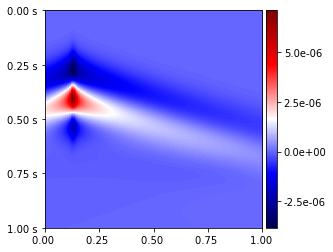

In [5]:
# spyro.plots.plot_shotrecords(
#             model, usol_rec, appear=True, name=str(0 + 1), save=False,legend=True
#         )

from matplotlib               import ticker
def graph2drec(rec):  
  
    
    tf  = model["timeaxis"]["tf"] 
    extent = [0,1, tf, 0]
    fig    = plot.imshow(rec[:][:], cmap="seismic", extent=extent)
    plot.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f '))
    plot.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f s'))
    ax = plot.gca()
    ax.xaxis.set_major_locator(plot.MaxNLocator(4))
    ax.yaxis.set_major_locator(plot.MaxNLocator(4))
    
    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    tick_locator = ticker.MaxNLocator(nbins=5)
    
    cbar = plot.colorbar(fig, cax=cax, format='%.1e')
    
    cbar.locator = tick_locator
    
    cbar.update_ticks()
    
    plot.draw()
     
    plot.show()
    plot.close()

    return
#==============================================================================

graph2drec(usol_rec[0])


In [ ]:
control = Control(vp)
dJdm    = Function(V)
for sn in range(0,model["acquisition"]["num_sources"]):
    dJdm += compute_gradient(J[sn], control)

In [ ]:
fig, axes = plot.subplots()
axes.set_aspect('equal')
colors = firedrake.tripcolor(dJdm, axes=axes, shading='gouraud', cmap="jet")

fig.colorbar(colors);
plot.savefig('grad.png',dpi=100,format='png')


In [ ]:
# J_total = sum(J)
# print(J)
# h = Function(V)
# h.vector()[:] = 0.1
# Jhat    = ReducedFunctional(J_total, control) 
# conv_rate = taylor_test(Jhat, vp, h)

In [ ]:
water = np.where(vp.dat.data[:] < 1.51)
dJdm.dat.data[water] = 0.0
File("grad_ad.pvd").write(dJdm)
File("vel.pvd").write(vp)